# Анализ прибыльности авиарейсов<br />(г. Анапа, 2017-й год)
## Власов Д. В. (группа dst-26)

## Загрузка библиотек для работы с данными

In [2]:
!pip install haversine

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import iqr

import datetime as dt

from haversine import haversine, Unit

### Настройка библиотек

In [4]:
pd.set_option('display.encoding', "UTF-8")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# pd.set_option('display.html.border', 2)
# pd.set_option('display.html.table_schema', True)

### Оформление

In [5]:
# from IPython.core.display import display, HTML


# def css_border(x):
#     return ["border-left: 2px solid black" if (i % 2 == 0) else "border-left: 2px solid black" for i, col in enumerate(x)]


# def pd_html(df: pd.DataFrame):
#     return HTML(( df.style.apply(css_border, axis=1).render() ))


# def display_pd_html(df: pd.DataFrame):
#     return display(pd_html(df))

## Подпрограммы работы с данными

### Подпрограммы для графического отображения данных

In [6]:
def get_boxplot(data: pd.DataFrame, column_x, column_y):
    """Рисование диаграммы boxplot для
    колонки column_x по оси абсцисс и колонки column_y по оси ординат.

    Parameters:
        data - общий набор данных, в колонке column которого найдены выбросы
        column_x - колонка с данными, откладываемыми по оси абсцисс
        column_y - колонка с данными, откладываемыми по оси ординат
    
    Returns:
        See description.
    """
    fig, ax = plt.subplots(figsize = (14, 4))

    column_x_values = list(data[column_x].unique())
    column_x_values.sort()
    sns.boxplot(
        x=column_x, y=column_y.name, 
        data=data,
        ax=ax,
        order=column_x_values)

    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column_x)
    plt.show()

## 1. Загрузка сырых данных

### 1.1 Загрузка данных о перелётах из Анапы в зимние месяцы 2017-го года

In [8]:
data_raw = pd.read_csv('../01-database-initial-exploration/initial_raw_dataset_2016_2017.csv')

In [9]:
data_raw.sample(5)

flight_id departure_airport arrival_airport      actual_departure  \
161     136187               AAQ             SVO  2016-12-01T10:09:00Z   
55      136937               AAQ             EGO  2017-01-03T09:29:00Z   
97      136284               AAQ             SVO  2017-02-07T10:07:00Z   
11      136523               AAQ             NOZ  2017-01-10T06:14:00Z   
116     136951               AAQ             EGO  2017-02-02T09:28:00Z   

           actual_arrival  departure_delay_mins  arrival_delay_mins  \
161  2016-12-01T11:49:00Z                   4.0                 4.0   
55   2017-01-03T10:19:00Z                   4.0                 4.0   
97   2017-02-07T11:48:00Z                   2.0                 3.0   
11   2017-01-10T11:26:00Z                   4.0                11.0   
116  2017-02-02T10:17:00Z                   3.0                 2.0   

     tickets_economy  seats_economy  economy_load  tickets_business  \
161              117            118      0.991525                12   
55                72             85      0.847059                 9   
97               107            118      0.906780                10   
11                 0            118      0.000000                 0   
116               78             85      0.917647                12   

     seats_business  business_load  tickets_all  seats  total_load  \
161              12       1.000000          129    130    0.992308   
55               12       0.750000           81     97    0.835052   
97               12       0.833333          117    130    0.900000   
11               12       0.000000            0    130    0.000000   
116              12       1.000000           90     97    0.927835   

     amount_economy  amount_business  amount_all aircraft_code  range  \
161       1434600.0         439200.0   1873800.0           733   4200   
55         456000.0         170100.0    626100.0           SU9   3000   
97        1311400.0         366000.0   1677400.0           733   4200   
11              0.0              0.0         0.0           733   4200   
116        493800.0         226800.0    720600.0           SU9   3000   

     departure_airport_latitude  departure_airport_longitude  \
161                   45.002102                    37.347301   
55                    45.002102                    37.347301   
97                    45.002102                    37.347301   
11                    45.002102                    37.347301   
116                   45.002102                    37.347301   

     arrival_airport_latitude  arrival_airport_longitude  
161                 55.972599                  37.414600  
55                  50.643799                  36.590099  
97                  55.972599                  37.414600  
11                  53.811401                  86.877197  
116                 50.643799                  36.590099

### 1.2 Загрузка дополнительных данных по моделям самолётов

In [10]:
data_aircraft = pd.read_csv('../01-database-initial-exploration/aircraft-data.csv')

In [11]:
data_aircraft.sample(2)

aircraft_id aircraft_code        aircraft_name  fuel_g_per_pass_km  \
0            1           733       Boeing 737-300               25.00   
1            2           SU9  Sukhoi Superjet-100               23.46   

   fuel_kg_per_hour  fuel_tank_volume_L  
0              2400               23830  
1              1800               15805

### 1.3 Загрузка цен для аэропортов<br />(цена на топливо, цена простоя за минуту,..)

<b>Замечание:</b><br />
Цена задержки за минуту рейса при вылете или прилёте судна ($38 - для Boeing 737-800)<br />
взята ориентировочно на основе оценки:<br />
[How much does it cost the airliner per minute when a plane is delayed?](https://www.quora.com/How-much-does-it-cost-the-airliner-per-minute-when-a-plane-is-delayed "How much does it cost the airliner per minute when a plane is delayed?")<br />
Курс доллара США взят примерно равным 60 рублям за 1 доллар для 2017-го года.

<div style="color: gray">
Другой вариант: https://www.airlines.org/dataset/per-minute-cost-of-delays-to-u-s-airlines/# .<br />
</div>

In [12]:
data_airport = pd.read_csv('../01-database-initial-exploration/airport-prices.csv')

In [13]:
data_airport.head(3)

year_month airport_code  fuel_price_rubles_per_ton  fuel_value_added_tax  \
0    2017-01          AAQ                      41435                  0.18   
1    2017-02          AAQ                      39553                  0.18   
2    2017-12          AAQ                      47101                  0.18   

   delay_cost_per_minute  
0                   2280  
1                   2280  
2                   2280

In [14]:
data_airport["year_month"] = pd.to_datetime(data_airport["year_month"], format="%Y-%m")

In [15]:
data_airport.head(16)

year_month airport_code  fuel_price_rubles_per_ton  fuel_value_added_tax  \
0  2017-01-01          AAQ                      41435                  0.18   
1  2017-02-01          AAQ                      39553                  0.18   
2  2017-12-01          AAQ                      47101                  0.18   
3  2016-12-01          AAQ                      38867                  0.18   
4  2017-01-01          EGO                      36864                  0.18   
5  2017-02-01          EGO                      36864                  0.18   
6  2017-12-01          EGO                      44068                  0.18   
7  2016-12-01          EGO                      34746                  0.18   
8  2017-01-01          SVO                      36853                  0.18   
9  2017-02-01          SVO                      36853                  0.18   
10 2017-12-01          SVO                      45300                  0.18   
11 2016-12-01          SVO                      36853                  0.18   
12 2017-01-01          NOZ                      36000                  0.18   
13 2017-02-01          NOZ                      36000                  0.18   
14 2017-12-01          NOZ                      46000                  0.18   
15 2016-12-01          NOZ                      36000                  0.18   

    delay_cost_per_minute  
0                    2280  
1                    2280  
2                    2280  
3                    2280  
4                    2280  
5                    2280  
6                    2280  
7                    2280  
8                    2280  
9                    2280  
10                   2280  
11                   2280  
12                   2280  
13                   2280  
14                   2280  
15                   2280

In [16]:
# data_airport.loc[data_airport.loc[:, "fuel_price_rubles_per_ton"].isin(data_airport.loc[:, "fuel_price_rubles_per_ton"].value_counts().index[:5])]

## 2. Добавление дополнительных данных к каждому рейсу

### 2.1 Предобработка колонок с датами и временем вылета/прилёта

In [17]:
data_raw["actual_departure"] = pd.to_datetime(data_raw["actual_departure"], format="%Y-%m-%dT%H:%M:%SZ")
data_raw["actual_arrival"] = pd.to_datetime(data_raw["actual_arrival"], format="%Y-%m-%dT%H:%M:%SZ")

### 2.2 Добавление колонок<br /><i>удельного расхода топлива</i> и<br/><i>часового расхода</i>

In [18]:
data = data_raw.join(data_aircraft.set_index("aircraft_code"), on="aircraft_code")
data.drop(["aircraft_id"], axis=1, inplace=True)
data = data.reindex(
    columns=[
        "flight_id", "departure_airport", "arrival_airport",
        "actual_departure", "actual_arrival", "departure_delay_mins", "arrival_delay_mins",
        "tickets_all", "seats", "total_load", "amount_all",
        "tickets_economy", "seats_economy", "economy_load",
        "tickets_business", "seats_business", "business_load",
        "amount_economy", "amount_business",
        "aircraft_code", "aircraft_name",
        "fuel_g_per_pass_km", "fuel_kg_per_hour", "fuel_tank_volume_L",
        "range",
        "departure_airport_latitude", "departure_airport_longitude",
        "arrival_airport_latitude", "arrival_airport_longitude"
    ]
)

In [19]:
data.sample(5)

flight_id departure_airport arrival_airport    actual_departure  \
7       136560               AAQ             NOZ 2017-01-24 06:13:00   
185     136785               AAQ             EGO 2016-12-29 09:28:00   
175     136742               AAQ             EGO 2016-12-18 09:27:00   
168     136758               AAQ             EGO 2017-01-12 09:26:00   
24      136922               AAQ             EGO 2017-02-11 09:27:00   

         actual_arrival  departure_delay_mins  arrival_delay_mins  \
7   2017-01-24 11:18:00                   3.0                 3.0   
185 2016-12-29 10:19:00                   3.0                 4.0   
175 2016-12-18 10:17:00                   2.0                 2.0   
168 2017-01-12 10:15:00                   1.0                 0.0   
24  2017-02-11 10:17:00                   2.0                 2.0   

     tickets_all  seats  total_load  amount_all  tickets_economy  \
7              0    130    0.000000         0.0                0   
185           97     97    1.000000    765300.0               85   
175           97     97    1.000000    765300.0               85   
168           97     97    1.000000    765300.0               85   
24            76     97    0.783505    607800.0               66   

     seats_economy  economy_load  tickets_business  seats_business  \
7              118      0.000000                 0              12   
185             85      1.000000                12              12   
175             85      1.000000                12              12   
168             85      1.000000                12              12   
24              85      0.776471                10              12   

     business_load  amount_economy  amount_business aircraft_code  \
7         0.000000             0.0              0.0           733   
185       1.000000        538500.0         226800.0           SU9   
175       1.000000        538500.0         226800.0           SU9   
168       1.000000        538500.0         226800.0           SU9   
24        0.833333        418800.0         189000.0           SU9   

           aircraft_name  fuel_g_per_pass_km  fuel_kg_per_hour  \
7         Boeing 737-300               25.00              2400   
185  Sukhoi Superjet-100               23.46              1800   
175  Sukhoi Superjet-100               23.46              1800   
168  Sukhoi Superjet-100               23.46              1800   
24   Sukhoi Superjet-100               23.46              1800   

     fuel_tank_volume_L  range  departure_airport_latitude  \
7                 23830   4200                   45.002102   
185               15805   3000                   45.002102   
175               15805   3000                   45.002102   
168               15805   3000                   45.002102   
24                15805   3000                   45.002102   

     departure_airport_longitude  arrival_airport_latitude  \
7                      37.347301                 53.811401   
185                    37.347301                 50.643799   
175                    37.347301                 50.643799   
168                    37.347301                 50.643799   
24                     37.347301                 50.643799   

     arrival_airport_longitude  
7                    86.877197  
185                  36.590099  
175                  36.590099  
168                  36.590099  
24                   36.590099

### 2.3 Добавление цен в аэропортах в общую таблицу

In [20]:
# Цена топлива за тонну
data.insert(
    data.columns.get_loc("departure_airport_latitude") - 1, "departure_fuel_price_per_ton", np.nan
)
data.insert(
    data.columns.get_loc("departure_fuel_price_per_ton") + 1, "arrival_fuel_price_per_ton", np.nan
)
# НДС (до 2019-го года НДС был 18%)
data.insert(
    data.columns.get_loc("arrival_fuel_price_per_ton") + 1, "fuel_value_added_tax", np.nan
)
# Стоимость задержки самолёта для аэропорта в минуту
data.insert(
    data.columns.get_loc("fuel_value_added_tax") + 1, "departure_delay_cost_min", np.nan
)
data.insert(
    data.columns.get_loc("departure_delay_cost_min") + 1, "arrival_delay_cost_min", np.nan
)

In [21]:
def airport_prices(data_row: pd.Series):
    departure_airport_code = data_row["departure_airport"]
    departure_date = data_row["actual_departure"]
    departure_date_year = departure_date.year
    departure_date_month = departure_date.month
    departure_monthly_prices = data_airport[
        (
            data_airport["airport_code"] == departure_airport_code
        ) & (
            (
                data_airport["year_month"].dt.year == departure_date_year
            ) & (
                data_airport["year_month"].dt.month == departure_date_month
            )
        )
    ]

    arrival_airport_code = data_row["arrival_airport"]
    arrival_date = data_row["actual_arrival"]
    arrival_date_year = arrival_date.year
    arrival_date_month = arrival_date.month
    arrival_monthly_prices = data_airport[
        (
            data_airport["airport_code"] == arrival_airport_code
        ) & (
            (
                data_airport["year_month"].dt.year == arrival_date_year
            ) & (
                data_airport["year_month"].dt.month == arrival_date_month
            )
        )
    ]

    data_row["departure_fuel_price_per_ton"] = \
        departure_monthly_prices["fuel_price_rubles_per_ton"].iloc[0]
    data_row["arrival_fuel_price_per_ton"] = \
        arrival_monthly_prices["fuel_price_rubles_per_ton"].iloc[0]

    # НДС одинаковый по стране
    data_row["fuel_value_added_tax"] = \
        departure_monthly_prices["fuel_value_added_tax"].iloc[0]

    data_row["departure_delay_cost_min"] = \
        departure_monthly_prices["delay_cost_per_minute"].iloc[0]
    data_row["arrival_delay_cost_min"] = \
        arrival_monthly_prices["delay_cost_per_minute"].iloc[0]
    
    return data_row

airport_columns = [
    "departure_airport", "arrival_airport",
    "actual_departure", "actual_arrival",
    "departure_fuel_price_per_ton", "arrival_fuel_price_per_ton",
    "fuel_value_added_tax",
    "departure_delay_cost_min", "arrival_delay_cost_min"
]
data[airport_columns] = data[airport_columns].apply(airport_prices, axis=1)


In [22]:
data.sample(5)

flight_id departure_airport arrival_airport    actual_departure  \
183     136793               AAQ             EGO 2016-12-06 09:31:00   
121     136387               AAQ             SVO 2017-01-19 10:08:00   
81      136428               AAQ             SVO 2017-01-21 10:08:00   
20      136250               AAQ             SVO 2017-02-08 10:06:00   
112     136164               AAQ             SVO 2017-01-07 10:07:00   

         actual_arrival  departure_delay_mins  arrival_delay_mins  \
183 2016-12-06 10:21:00                   6.0                 6.0   
121 2017-01-19 11:47:00                   3.0                 2.0   
81  2017-01-21 11:47:00                   3.0                 2.0   
20  2017-02-08 11:47:00                   1.0                 2.0   
112 2017-01-07 11:46:00                   2.0                 1.0   

     tickets_all  seats  total_load  amount_all  tickets_economy  \
183           97     97    1.000000    765300.0               85   
121          121    130    0.930769   1775000.0              109   
81           115    130    0.884615   1678600.0              104   
20            99    130    0.761538   1407800.0               91   
112          120    130    0.923077   1738400.0              109   

     seats_economy  economy_load  tickets_business  seats_business  \
183             85      1.000000                12              12   
121            118      0.923729                12              12   
81             118      0.881356                11              12   
20             118      0.771186                 8              12   
112            118      0.923729                11              12   

     business_load  amount_economy  amount_business aircraft_code  \
183       1.000000        538500.0         226800.0           SU9   
121       1.000000       1335800.0         439200.0           733   
81        0.916667       1276000.0         402600.0           733   
20        0.666667       1115000.0         292800.0           733   
112       0.916667       1335800.0         402600.0           733   

           aircraft_name  fuel_g_per_pass_km  fuel_kg_per_hour  \
183  Sukhoi Superjet-100               23.46              1800   
121       Boeing 737-300               25.00              2400   
81        Boeing 737-300               25.00              2400   
20        Boeing 737-300               25.00              2400   
112       Boeing 737-300               25.00              2400   

     fuel_tank_volume_L  departure_fuel_price_per_ton  \
183               15805                         38867   
121               23830                         41435   
81                23830                         41435   
20                23830                         39553   
112               23830                         41435   

     arrival_fuel_price_per_ton  fuel_value_added_tax  \
183                       34746                  0.18   
121                       36853                  0.18   
81                        36853                  0.18   
20                        36853                  0.18   
112                       36853                  0.18   

     departure_delay_cost_min  arrival_delay_cost_min  range  \
183                      2280                    2280   3000   
121                      2280                    2280   4200   
81                       2280                    2280   4200   
20                       2280                    2280   4200   
112                      2280                    2280   4200   

     departure_airport_latitude  departure_airport_longitude  \
183                   45.002102                    37.347301   
121                   45.002102                    37.347301   
81                    45.002102                    37.347301   
20                    45.002102                    37.347301   
112                   45.002102                    37.347301   

     arrival_airport_latitude  arrival_airport_longitude  


### 2.4 Добавление порядкового номера зимнего месяца
1 - декабрь 2016 - Dec<br />
2 - январь 2017 - Jan<br />
3 - февраль 2017 - Feb

In [23]:
data.insert(
    data.columns.get_loc("actual_departure") - 1, "winter_month", np.nan
)

In [24]:
def fill_winter_month(data_row: pd.Series):
    departure = data_row["actual_departure"]
    month = "01-Dec" if departure.month == 12 \
        else "02-Jan" if departure.month == 1 \
            else "03-Feb" if departure.month == 2 \
                else np.nan

    data_row["winter_month"] = month

    return data_row

data_columns = [
    "actual_departure",
    "winter_month"
]
data[data_columns] = data[data_columns].apply(fill_winter_month, axis=1)

In [25]:
data.winter_month[data.winter_month.isna()].shape[0]

0

In [26]:
data.sample(3)

flight_id departure_airport winter_month arrival_airport  \
19      136360               AAQ       03-Feb             SVO   
191     136368               AAQ       01-Dec             SVO   
129     136131               AAQ       02-Jan             SVO   

       actual_departure      actual_arrival  departure_delay_mins  \
19  2017-02-05 10:08:00 2017-02-05 11:48:00                   3.0   
191 2016-12-31 10:07:00 2016-12-31 11:47:00                   2.0   
129 2017-01-28 10:07:00 2017-01-28 11:46:00                   2.0   

     arrival_delay_mins  tickets_all  seats  total_load  amount_all  \
19                  3.0           97    130    0.746154   1455400.0   
191                 2.0          130    130    1.000000   1886000.0   
129                 1.0          124    130    0.953846   1812800.0   

     tickets_economy  seats_economy  economy_load  tickets_business  \
19                86            118      0.728814                11   
191              118            118      1.000000                12   
129              112            118      0.949153                12   

     seats_business  business_load  amount_economy  amount_business  \
19               12       0.916667       1052800.0         402600.0   
191              12       1.000000       1446800.0         439200.0   
129              12       1.000000       1373600.0         439200.0   

    aircraft_code   aircraft_name  fuel_g_per_pass_km  fuel_kg_per_hour  \
19            733  Boeing 737-300                25.0              2400   
191           733  Boeing 737-300                25.0              2400   
129           733  Boeing 737-300                25.0              2400   

     fuel_tank_volume_L  departure_fuel_price_per_ton  \
19                23830                         39553   
191               23830                         38867   
129               23830                         41435   

     arrival_fuel_price_per_ton  fuel_value_added_tax  \
19                        36853                  0.18   
191                       36853                  0.18   
129                       36853                  0.18   

     departure_delay_cost_min  arrival_delay_cost_min  range  \
19                       2280                    2280   4200   
191                      2280                    2280   4200   
129                      2280                    2280   4200   

     departure_airport_latitude  departure_airport_longitude  \
19                    45.002102                    37.347301   
191                   45.002102                    37.347301   
129                   45.002102                    37.347301   

     arrival_airport_latitude  arrival_airport_longitude  
19                  55.972599                    37.4146  
191                 55.972599                    37.4146  
129                 55.972599                    37.4146

### 2.5 Добавление порядкового номера дня, начиная с первого дня декабря и заканчивая последним днём февраля

In [27]:
data.insert(
    data.columns.get_loc("winter_month") - 1, "winter_day", np.nan
)

In [28]:
def fill_winter_month(data_row: pd.Series):
    departure = data_row["actual_departure"]

    day_shift = 0 if departure.month == 12 \
        else 31 if departure.month == 1 \
            else 62 if departure.month == 2 \
                else np.nan

    day_number = day_shift + departure.day

    data_row["winter_day"] = day_number

    return data_row

data_columns = [
    "actual_departure",
    "winter_day"
]
data[data_columns] = data[data_columns].apply(fill_winter_month, axis=1)

In [29]:
data.sample(3)

flight_id  winter_day departure_airport winter_month arrival_airport  \
66      136771          17               AAQ       01-Dec             EGO   
85      136447          11               AAQ       01-Dec             SVO   
141     136720          57               AAQ       02-Jan             EGO   

       actual_departure      actual_arrival  departure_delay_mins  \
66  2016-12-17 09:26:00 2016-12-17 10:15:00                   1.0   
85  2016-12-11 10:07:00 2016-12-11 11:47:00                   2.0   
141 2017-01-26 09:29:00 2017-01-26 10:19:00                   4.0   

     arrival_delay_mins  tickets_all  seats  total_load  amount_all  \
66                  0.0           82     97    0.845361    657000.0   
85                  2.0          116    130    0.892308   1642000.0   
141                 4.0           95     97    0.979381    752700.0   

     tickets_economy  seats_economy  economy_load  tickets_business  \
66                71             85      0.835294                11   
85               107            118      0.906780                 9   
141               83             85      0.976471                12   

     seats_business  business_load  amount_economy  amount_business  \
66               12       0.916667        449100.0         207900.0   
85               12       0.750000       1312600.0         329400.0   
141              12       1.000000        525900.0         226800.0   

    aircraft_code        aircraft_name  fuel_g_per_pass_km  fuel_kg_per_hour  \
66            SU9  Sukhoi Superjet-100               23.46              1800   
85            733       Boeing 737-300               25.00              2400   
141           SU9  Sukhoi Superjet-100               23.46              1800   

     fuel_tank_volume_L  departure_fuel_price_per_ton  \
66                15805                         38867   
85                23830                         38867   
141               15805                         41435   

     arrival_fuel_price_per_ton  fuel_value_added_tax  \
66                        34746                  0.18   
85                        36853                  0.18   
141                       36864                  0.18   

     departure_delay_cost_min  arrival_delay_cost_min  range  \
66                       2280                    2280   3000   
85                       2280                    2280   4200   
141                      2280                    2280   3000   

     departure_airport_latitude  departure_airport_longitude  \
66                    45.002102                    37.347301   
85                    45.002102                    37.347301   
141                   45.002102                    37.347301   

     arrival_airport_latitude  arrival_airport_longitude  
66                  50.643799                  36.590099  
85                  55.972599                  37.414600  
141                 50.643799                  36.590099

## 3. Подпрограммы для расчёта затрат на рейс по расходу топлива

### 3.1 Затраченное топливо в тоннах по<br /><i>расходу топлива за час полёта</i> - килограмм / час

In [30]:
def fuel_expenditures_time(departure, arrival, fuel_kg_per_hour):
    flight_timedelta = arrival - departure
    duration_hours = flight_timedelta.total_seconds() / 3600

    fuel_consumed_ton = (duration_hours * fuel_kg_per_hour) / 1000

    return fuel_consumed_ton

In [31]:
data[data.flight_id == 136270]

flight_id  winter_day departure_airport winter_month arrival_airport  \
72     136270          74               AAQ       03-Feb             SVO   

      actual_departure      actual_arrival  departure_delay_mins  \
72 2017-02-12 10:12:00 2017-02-12 11:51:00                   7.0   

    arrival_delay_mins  tickets_all  seats  total_load  amount_all  \
72                 6.0          111    130    0.853846   1628600.0   

    tickets_economy  seats_economy  economy_load  tickets_business  \
72              100            118      0.847458                11   

    seats_business  business_load  amount_economy  amount_business  \
72              12       0.916667       1226000.0         402600.0   

   aircraft_code   aircraft_name  fuel_g_per_pass_km  fuel_kg_per_hour  \
72           733  Boeing 737-300                25.0              2400   

    fuel_tank_volume_L  departure_fuel_price_per_ton  \
72               23830                         39553   

    arrival_fuel_price_per_ton  fuel_value_added_tax  \
72                       36853                  0.18   

    departure_delay_cost_min  arrival_delay_cost_min  range  \
72                      2280                    2280   4200   

    departure_airport_latitude  departure_airport_longitude  \
72                   45.002102                    37.347301   

    arrival_airport_latitude  arrival_airport_longitude  
72                 55.972599                    37.4146

In [32]:
# Тест для flight_id = 136270
test_departure = dt.datetime(2017, 2, 12, 10, 12, 00)
test_arrival = dt.datetime(2017, 2, 12, 11, 51, 00)
test_fuel_kg_per_hour = 2400
fuel_expenditures_time(test_departure, test_arrival, test_fuel_kg_per_hour)

3.96

### 3.2 Затраченной топливо в тоннах по<br />его <i>удельному расходу</i> - грамм / (пассажир $\cdot$ километр)

In [33]:
def fuel_expenditures_distance(
    departure_coordinates: tuple, arrival_coordinates: tuple,
    passengers: int,
    fuel_g_per_pass_km: float):
    departure_latitude = departure_coordinates[0]
    departure_longitude = departure_coordinates[1]
    arrival_latitude = arrival_coordinates[0]
    arrival_longitude = arrival_coordinates[1]

    distance_kilometers = haversine(
        (departure_latitude, departure_longitude),
        (arrival_latitude, arrival_longitude),
        unit=Unit.KILOMETERS
    )

    fuel_consumed_ton = (fuel_g_per_pass_km * passengers * distance_kilometers) / (1000 * 1000)

    return fuel_consumed_ton

In [34]:
data[data.flight_id == 136270]

flight_id  winter_day departure_airport winter_month arrival_airport  \
72     136270          74               AAQ       03-Feb             SVO   

      actual_departure      actual_arrival  departure_delay_mins  \
72 2017-02-12 10:12:00 2017-02-12 11:51:00                   7.0   

    arrival_delay_mins  tickets_all  seats  total_load  amount_all  \
72                 6.0          111    130    0.853846   1628600.0   

    tickets_economy  seats_economy  economy_load  tickets_business  \
72              100            118      0.847458                11   

    seats_business  business_load  amount_economy  amount_business  \
72              12       0.916667       1226000.0         402600.0   

   aircraft_code   aircraft_name  fuel_g_per_pass_km  fuel_kg_per_hour  \
72           733  Boeing 737-300                25.0              2400   

    fuel_tank_volume_L  departure_fuel_price_per_ton  \
72               23830                         39553   

    arrival_fuel_price_per_ton  fuel_value_added_tax  \
72                       36853                  0.18   

    departure_delay_cost_min  arrival_delay_cost_min  range  \
72                      2280                    2280   4200   

    departure_airport_latitude  departure_airport_longitude  \
72                   45.002102                    37.347301   

    arrival_airport_latitude  arrival_airport_longitude  
72                 55.972599                    37.4146

In [35]:
# Тест для flight_id = 136270
test_departure_coordinates = (45.002102, 37.347301)
test_arrival_coordinates = (55.972599, 37.414600)
# Предположим, что загрузка полная (130 вместо 111):
test_passengers = 130
test_fuel_g_per_pass_km = 25.00
fuel_expenditures_distance(
    test_departure_coordinates,
    test_arrival_coordinates,
    test_passengers,
    test_fuel_g_per_pass_km
)

3.9645919036305552

In [36]:
# Для 111 пассажиров:
fuel_expenditures_distance(
    test_departure_coordinates,
    test_arrival_coordinates,
    111,
    test_fuel_g_per_pass_km
)

3.3851515484845507

<b>Промежуточное решение:</b><br />
необходимо взять за основу расчёты, получаемые из <i>удельного расхода топлива</i>,<br />
измеряемого в граммах на пассажира на километр. Это позволит точнее рассчитать<br />
затраты на топливо при неполнолной загруженности рейса.

## 4. Потреблённое топливо для каждого рейса

In [37]:
data.insert(
    data.columns.get_loc("amount_all") + 1, "fuel_consumed_ton", np.nan
)

In [38]:
def fill_fuel_consumed_ton(data_row: pd.Series):
    departure_coordinates = (
        data_row["departure_airport_latitude"],
        data_row["departure_airport_longitude"]
    )
    arrival_coordinates = (
        data_row["arrival_airport_latitude"],
        data_row["arrival_airport_longitude"]
    )

    passengers = data_row["tickets_all"]

    fuel_g_per_pass_km = data_row["fuel_g_per_pass_km"]

    fuel_expenditures = fuel_expenditures_distance(
        departure_coordinates,
        arrival_coordinates,
        passengers,
        fuel_g_per_pass_km
    )

    data_row["fuel_consumed_ton"] = fuel_expenditures
    
    return data_row

data_columns = [
    "departure_airport_latitude", "departure_airport_longitude",
    "arrival_airport_latitude", "arrival_airport_longitude",
    "tickets_all",
    "fuel_g_per_pass_km",
    "fuel_consumed_ton"
]
data[data_columns] = data[data_columns].apply(fill_fuel_consumed_ton, axis=1)

In [39]:
data[data.flight_id == 136270]

flight_id  winter_day departure_airport winter_month arrival_airport  \
72     136270          74               AAQ       03-Feb             SVO   

      actual_departure      actual_arrival  departure_delay_mins  \
72 2017-02-12 10:12:00 2017-02-12 11:51:00                   7.0   

    arrival_delay_mins  tickets_all  seats  total_load  amount_all  \
72                 6.0        111.0    130    0.853846   1628600.0   

    fuel_consumed_ton  tickets_economy  seats_economy  economy_load  \
72           3.385152              100            118      0.847458   

    tickets_business  seats_business  business_load  amount_economy  \
72                11              12       0.916667       1226000.0   

    amount_business aircraft_code   aircraft_name  fuel_g_per_pass_km  \
72         402600.0           733  Boeing 737-300                25.0   

    fuel_kg_per_hour  fuel_tank_volume_L  departure_fuel_price_per_ton  \
72              2400               23830                         39553   

    arrival_fuel_price_per_ton  fuel_value_added_tax  \
72                       36853                  0.18   

    departure_delay_cost_min  arrival_delay_cost_min  range  \
72                      2280                    2280   4200   

    departure_airport_latitude  departure_airport_longitude  \
72                   45.002102                    37.347301   

    arrival_airport_latitude  arrival_airport_longitude  
72                 55.972599                    37.4146

## 5. Финансовые затраты на топливо для каждого рейса

Принято решение вычислять затраты на топливо для рейса в одну сторону<br />
исходя из того, что самолёт, выполняющий регулярно один и тот же рейс,<br />
полностью дозаправляется в каждом аэропорту, предварительно затратив топливо,<br />
которым он заправился в предыдущем аэропорту. Тогда затраты на топливо<br />
с учетом непроизводительного налета 3% можно приблизительно рассчитать по формуле:
$$
fuel\_cost\_per\_flight = 1.03 \cdot fuel\_consumed\_ton \cdot departure\_fuel\_price\_per\_ton\,.
$$
Даже если дозаправка и не происходит каждый раз до вылета,<br />
то в какой-то момент объём баков нужно будет заполнить б'ольшим<br />
объёмом топлива.

С учётом того, что цена на топливо дана изначально без НДС (value-added tax),<br />
окончательно можно записать:
$$
fuel\_cost\_per\_flight =
    1.03 \cdot fuel\_consumed\_ton \cdot departure\_fuel\_price\_per\_ton \\
    \times (1 + fuel\_value\_added\_tax)
$$

In [40]:
data.insert(
    data.columns.get_loc("fuel_consumed_ton") + 1, "fuel_cost_per_flight", np.nan
)

In [41]:
def fill_fuel_cost_per_flight(data_row: pd.Series):
    departure_price_ton = data_row["departure_fuel_price_per_ton"]
    value_added_tax = data_row["fuel_value_added_tax"]
    fuel_consumed_ton = data_row["fuel_consumed_ton"]

    fuel_cost_per_flight = 0.0 if data_row["tickets_all"] <= 0 else \
        1.03 * fuel_consumed_ton * departure_price_ton * (1 + value_added_tax)

    data_row["fuel_cost_per_flight"] = fuel_cost_per_flight

    return data_row

data_columns = [
    "departure_fuel_price_per_ton",
    "fuel_value_added_tax",
    "fuel_consumed_ton",
    "tickets_all",
    "fuel_cost_per_flight"
]
data[data_columns] = data[data_columns].apply(fill_fuel_cost_per_flight, axis=1)

In [42]:
data.sample(5)

flight_id  winter_day departure_airport winter_month arrival_airport  \
93      136738          20               AAQ       01-Dec             EGO   
156     136778          84               AAQ       03-Feb             EGO   
139     136706          37               AAQ       02-Jan             EGO   
177     136617          27               AAQ       01-Dec             EGO   
158     136873           3               AAQ       01-Dec             EGO   

       actual_departure      actual_arrival  departure_delay_mins  \
93  2016-12-20 09:27:00 2016-12-20 10:16:00                   2.0   
156 2017-02-22 09:26:00 2017-02-22 10:16:00                   1.0   
139 2017-01-06 09:30:00 2017-01-06 10:20:00                   5.0   
177 2016-12-27 09:26:00 2016-12-27 10:16:00                   1.0   
158 2016-12-03 09:26:00 2016-12-03 10:17:00                   1.0   

     arrival_delay_mins  tickets_all  seats  total_load  amount_all  \
93                  1.0         87.0     97    0.896907    689700.0   
156                 1.0         96.0     97    0.989691    759000.0   
139                 5.0         95.0     97    0.979381    740100.0   
177                 1.0         97.0     97    1.000000    765300.0   
158                 2.0         96.0     97    0.989691    759000.0   

     fuel_consumed_ton  fuel_cost_per_flight  tickets_economy  seats_economy  \
93            1.285560          60728.495731               76             85   
156           1.418549          68193.489320               84             85   
139           1.403772          70694.104758               84             85   
177           1.433325          67708.782597               85             85   
158           1.418549          67010.753910               84             85   

     economy_load  tickets_business  seats_business  business_load  \
93       0.894118                11              12       0.916667   
156      0.988235                12              12       1.000000   
139      0.988235                11              12       0.916667   
177      1.000000                12              12       1.000000   
158      0.988235                12              12       1.000000   

     amount_economy  amount_business aircraft_code        aircraft_name  \
93         481800.0         207900.0           SU9  Sukhoi Superjet-100   
156        532200.0         226800.0           SU9  Sukhoi Superjet-100   
139        532200.0         207900.0           SU9  Sukhoi Superjet-100   
177        538500.0         226800.0           SU9  Sukhoi Superjet-100   
158        532200.0         226800.0           SU9  Sukhoi Superjet-100   

     fuel_g_per_pass_km  fuel_kg_per_hour  fuel_tank_volume_L  \
93                23.46              1800               15805   
156               23.46              1800               15805   
139               23.46              1800               15805   
177               23.46              1800               15805   
158               23.46              1800               15805   

     departure_fuel_price_per_ton  arrival_fuel_price_per_ton  \
93                        38867.0                       34746   
156                       39553.0                       36864   
139                       41435.0                       36864   
177                       38867.0                       34746   
158                       38867.0                       34746   

     fuel_value_added_tax  departure_delay_cost_min  arrival_delay_cost_min  \
93                   0.18                      2280                    2280   
156                  0.18                      2280                    2280   
139                  0.18                      2280                    2280   
177                  0.18                      2280                    2280   
158                  0.18                      2280                    2280   

     range  departure_airport_latitude  departure_airport_longitude  \
93    3000         

## 6. Финансовые затраты от задержек вылетов и опозданий рейсов


In [43]:
data.insert(
    data.columns.get_loc("fuel_cost_per_flight") + 1, "delay_cost_per_flight", np.nan
)

In [44]:
def fill_delay_cost_per_flight(data_row: pd.Series):
    # Допустим, что простой самолёта более 20-ти минут означает,
    # что он встал фактически на стоянку. В этом случае
    # стоянка до 3-х часов в аэропорту обычно бесплатна.
    # Иначе такие затраты будут астрономическими.
    # Также, если самолёт не прилетает долгое время, то
    # аэропорт прибытия уже не берёт деньги за некий простой, а
    # переключается на другие рейсы.

    # Бесплатное время длительного простоя на парковке - 3 часа
    max_free_parking_time_mins = 180

    departure_delay_minutes = data_row["departure_delay_mins"]
    departure_delay_minutes = 0.0 if departure_delay_minutes < 0 else departure_delay_minutes

    # if departure_delay_minutes > max_free_parking_time_mins:
    #     print(f"The flight {data['flight_id']} was in a parking state for a long time: {departure_delay_minutes} minutes.")

    departure_delay_minutes = \
        departure_delay_minutes if departure_delay_minutes <= 20 \
            else 0.0 if departure_delay_minutes <= max_free_parking_time_mins \
                else (departure_delay_minutes - max_free_parking_time_mins)

    arrival_delay_minutes = data_row["arrival_delay_mins"]
    arrival_delay_minutes = 0.0 if arrival_delay_minutes < 0 else arrival_delay_minutes

    arrival_delay_minutes = 0.0 if arrival_delay_minutes > 20 else arrival_delay_minutes

    delay_cost_per_flight = 0.0 if data_row["tickets_all"] <= 0 else \
        departure_delay_minutes * data_row["departure_delay_cost_min"] \
            + arrival_delay_minutes * data_row["arrival_delay_cost_min"]

    data_row["delay_cost_per_flight"] = delay_cost_per_flight

    return data_row

data_columns = [
    "flight_id",
    "departure_delay_mins", "arrival_delay_mins",
    "departure_delay_cost_min", "arrival_delay_cost_min",
    "tickets_all",
    "delay_cost_per_flight"
]
data[data_columns] = data[data_columns].apply(fill_delay_cost_per_flight, axis=1)

In [45]:
data.sample(5)

flight_id  winter_day departure_airport winter_month arrival_airport  \
132   136275.0          44               AAQ       02-Jan             SVO   
96    136310.0          53               AAQ       02-Jan             SVO   
190   136226.0          61               AAQ       02-Jan             SVO   
83    136159.0          35               AAQ       02-Jan             SVO   
108   136592.0          25               AAQ       01-Dec             EGO   

       actual_departure      actual_arrival  departure_delay_mins  \
132 2017-01-13 10:08:00 2017-01-13 11:46:00                   3.0   
96  2017-01-22 10:07:00 2017-01-22 11:47:00                   2.0   
190 2017-01-30 10:08:00 2017-01-30 11:48:00                   3.0   
83  2017-01-04 10:07:00 2017-01-04 11:45:00                   2.0   
108 2016-12-25 09:28:00 2016-12-25 10:18:00                   3.0   

     arrival_delay_mins  tickets_all  seats  total_load  amount_all  \
132                 1.0        125.0    130    0.961538   1825000.0   
96                  2.0        117.0    130    0.900000   1654200.0   
190                 3.0        130.0    130    1.000000   1886000.0   
83                  0.0        115.0    130    0.884615   1700600.0   
108                 3.0         89.0     97    0.917526    677100.0   

     fuel_consumed_ton  fuel_cost_per_flight  delay_cost_per_flight  \
132           3.812108         191978.117878                 9120.0   
96            3.568133         179691.518333                 9120.0   
190           3.964592         199657.242593                13680.0   
83            3.507139         176619.868447                 4560.0   
108           1.315113          62124.553104                13680.0   

     tickets_economy  seats_economy  economy_load  tickets_business  \
132              113            118      0.957627                12   
96               108            118      0.915254                 9   
190              118            118      1.000000                12   
83               103            118      0.872881                12   
108               80             85      0.941176                 9   

     seats_business  business_load  amount_economy  amount_business  \
132              12           1.00       1385800.0         439200.0   
96               12           0.75       1324800.0         329400.0   
190              12           1.00       1446800.0         439200.0   
83               12           1.00       1261400.0         439200.0   
108              12           0.75        507000.0         170100.0   

    aircraft_code        aircraft_name  fuel_g_per_pass_km  fuel_kg_per_hour  \
132           733       Boeing 737-300               25.00              2400   
96            733       Boeing 737-300               25.00              2400   
190           733       Boeing 737-300               25.00              2400   
83            733       Boeing 737-300               25.00              2400   
108           SU9  Sukhoi Superjet-100               23.46              1800   

     fuel_tank_volume_L  departure_fuel_price_per_ton  \
132               23830                       41435.0   
96                23830                       41435.0   
190               23830                       41435.0   
83                23830                       41435.0   
108               15805                       38867.0   

     arrival_fuel_price_per_ton  fuel_value_added_tax  \
132                       36853                  0.18   
96                        36853                  0.18   
190                       36853                  0.18   
83                        36853                  0.18   
108                       34746                  0.18   

     departure_delay_cost_min  arrival_delay_cost_min  range  \
132                    2280.0                  2280.0   4200   
96                     2280.0                  2280.0   4200   
190                    2280.0                  2280.0   4200

## 7. Общие финансовые затраты за рейс

In [46]:
data.insert(
    data.columns.get_loc("delay_cost_per_flight") + 1, "total_cost_per_flight", np.nan
)

In [47]:
def fill_delay_cost_per_flight(data_row: pd.Series):
    total_cost_per_flight = 0.0 if data_row["tickets_all"] <= 0 else \
        data_row["fuel_cost_per_flight"] + data_row["delay_cost_per_flight"]

    data_row["total_cost_per_flight"] = total_cost_per_flight

    return data_row

data_columns = [
    "tickets_all",
    "fuel_cost_per_flight",
    "delay_cost_per_flight",
    "total_cost_per_flight"
]
data[data_columns] = data[data_columns].apply(fill_delay_cost_per_flight, axis=1)

In [48]:
data.sample(5)

flight_id  winter_day departure_airport winter_month arrival_airport  \
133   136943.0           5               AAQ       01-Dec             EGO   
19    136360.0          67               AAQ       03-Feb             SVO   
40    136888.0          76               AAQ       03-Feb             EGO   
191   136368.0          31               AAQ       01-Dec             SVO   
119   136754.0          68               AAQ       03-Feb             EGO   

       actual_departure      actual_arrival  departure_delay_mins  \
133 2016-12-05 09:28:00 2016-12-05 10:18:00                   3.0   
19  2017-02-05 10:08:00 2017-02-05 11:48:00                   3.0   
40  2017-02-14 09:29:00 2017-02-14 10:19:00                   4.0   
191 2016-12-31 10:07:00 2016-12-31 11:47:00                   2.0   
119 2017-02-06 09:29:00 2017-02-06 10:18:00                   4.0   

     arrival_delay_mins  tickets_all  seats  total_load  amount_all  \
133                 3.0         94.0     97    0.969072    733800.0   
19                  3.0         97.0    130    0.746154   1455400.0   
40                  4.0         79.0     97    0.814433    626100.0   
191                 2.0        130.0    130    1.000000   1886000.0   
119                 3.0         90.0     97    0.927835    721200.0   

     fuel_consumed_ton  fuel_cost_per_flight  delay_cost_per_flight  \
133           1.388996          65614.696537                13680.0   
19            2.958196         142208.493911                13680.0   
40            1.167347          56117.558920                18240.0   
191           3.964592         187283.167560                 9120.0   
119           1.329889          63931.396238                15960.0   

     total_cost_per_flight  tickets_economy  seats_economy  economy_load  \
133           79294.696537               83             85      0.976471   
19           155888.493911               86            118      0.728814   
40            74357.558920               69             85      0.811765   
191          196403.167560              118            118      1.000000   
119           79891.396238               78             85      0.917647   

     tickets_business  seats_business  business_load  amount_economy  \
133                11              12       0.916667        525900.0   
19                 11              12       0.916667       1052800.0   
40                 10              12       0.833333        437100.0   
191                12              12       1.000000       1446800.0   
119                12              12       1.000000        494400.0   

     amount_business aircraft_code        aircraft_name  fuel_g_per_pass_km  \
133         207900.0           SU9  Sukhoi Superjet-100               23.46   
19          402600.0           733       Boeing 737-300               25.00   
40          189000.0           SU9  Sukhoi Superjet-100               23.46   
191         439200.0           733       Boeing 737-300               25.00   
119         226800.0           SU9  Sukhoi Superjet-100               23.46   

     fuel_kg_per_hour  fuel_tank_volume_L  departure_fuel_price_per_ton  \
133              1800               15805                       38867.0   
19               2400               23830                       39553.0   
40               1800               15805                       39553.0   
191              2400               23830                       38867.0   
119              1800               15805                       39553.0   

     arrival_fuel_price_per_ton  fuel_value_added_tax  \
133                       34746                  0.18   
19                        36853                  0.18   
40                        36864                  0.18   
191                       36853                  0.18   
119                       36864                  0.18   

     departure_delay_cost_min  arrival_delay_cost_min  range  \
133                    2280.0                  228

## 8. Прибыль за каждый рейс

In [49]:
data.insert(
    data.columns.get_loc("total_cost_per_flight") + 1, "total_profit_per_flight", np.nan
)

In [50]:
def fill_total_profit_per_flight(data_row: pd.Series):
    total_profit_per_flight = 0.0 if data_row["tickets_all"] <= 0 else \
        data_row["amount_all"] - data_row["total_cost_per_flight"]

    data_row["total_profit_per_flight"] = total_profit_per_flight

    return data_row

data_columns = [
    "tickets_all",
    "amount_all",
    "total_cost_per_flight",
    "total_profit_per_flight"
]
data[data_columns] = data[data_columns].apply(fill_total_profit_per_flight, axis=1)

In [51]:
data.sample(5)

flight_id  winter_day departure_airport winter_month arrival_airport  \
152   136649.0          49               AAQ       02-Jan             EGO   
112   136164.0          38               AAQ       02-Jan             SVO   
35    136843.0           4               AAQ       01-Dec             EGO   
45    136204.0          85               AAQ       03-Feb             SVO   
95    136855.0          42               AAQ       02-Jan             EGO   

       actual_departure      actual_arrival  departure_delay_mins  \
152 2017-01-18 09:25:00 2017-01-18 10:15:00                   0.0   
112 2017-01-07 10:07:00 2017-01-07 11:46:00                   2.0   
35  2016-12-04 09:30:00 2016-12-04 10:20:00                   5.0   
45  2017-02-23 10:06:00 2017-02-23 11:46:00                   1.0   
95  2017-01-11 12:07:00 2017-01-11 12:57:00                 162.0   

     arrival_delay_mins  tickets_all  seats  total_load  amount_all  \
152                 0.0         96.0     97    0.989691    759000.0   
112                 1.0        120.0    130    0.923077   1738400.0   
35                  5.0         78.0     97    0.804124    632400.0   
45                  1.0        107.0    130    0.823077   1457800.0   
95                162.0         87.0     97    0.896907    702300.0   

     fuel_consumed_ton  fuel_cost_per_flight  delay_cost_per_flight  \
152           1.418549          71438.253229                    0.0   
112           3.659623         184298.993163                 6840.0   
35            1.152571          54446.237552                22800.0   
45            3.263164         156869.163387                 4560.0   
95            1.285560          64740.916989                    0.0   

     total_cost_per_flight  total_profit_per_flight  tickets_economy  \
152           71438.253229             6.875617e+05               84   
112          191138.993163             1.547261e+06              109   
35            77246.237552             5.551538e+05               67   
45           161429.163387             1.296371e+06              101   
95            64740.916989             6.375591e+05               75   

     seats_economy  economy_load  tickets_business  seats_business  \
152             85      0.988235                12              12   
112            118      0.923729                11              12   
35              85      0.788235                11              12   
45             118      0.855932                 6              12   
95              85      0.882353                12              12   

     business_load  amount_economy  amount_business aircraft_code  \
152       1.000000        532200.0         226800.0           SU9   
112       0.916667       1335800.0         402600.0           733   
35        0.916667        424500.0         207900.0           SU9   
45        0.500000       1238200.0         219600.0           733   
95        1.000000        475500.0         226800.0           SU9   

           aircraft_name  fuel_g_per_pass_km  fuel_kg_per_hour  \
152  Sukhoi Superjet-100               23.46              1800   
112       Boeing 737-300               25.00              2400   
35   Sukhoi Superjet-100               23.46              1800   
45        Boeing 737-300               25.00              2400   
95   Sukhoi Superjet-100               23.46              1800   

     fuel_tank_volume_L  departure_fuel_price_per_ton  \
152               15805                       41435.0   
112               23830                       41435.0   
35                15805                       38867.0   
45                23830                       39553.0   
95                15805                       41435.0   

     arrival_fuel_price_per_ton  fuel_value_added_tax  \
152                       36864                  0.18   
112                       36853                  0.18   
35                        34746                  0.18   
45                        36853     

In [52]:
round(data["total_profit_per_flight"].sum())

188831099

## 9. Удаление форсмажорных случаев из анализа

In [53]:
data = data[data.departure_delay_mins <= 20]

In [54]:
round(data["total_profit_per_flight"].sum())

185770975

In [55]:
data.shape

(189, 41)

## 10. Удаление пустых рейсов
Пустые рейсы удаляются из анализа

In [56]:
data = data[data.tickets_all > 0]

In [57]:
data.shape

(176, 41)

## 12. Удаление признаков для упрощения анализа
Некоторые признаки, например деление по классам билетов,<br />
всё-таки стоит удалить, поскольку нет простого способа проанализировать<br />
влияние наполняемости по классам на прибыльность.<br />
Билетов бизнес-класса при этом всегда значительно меньше.

In [58]:
dataset = data[[
    'flight_id', 'departure_airport', 'arrival_airport',
    'winter_day', 'winter_month',
    'actual_departure', 'actual_arrival', 'departure_delay_mins', 'arrival_delay_mins',
    'tickets_all', 'total_load',
    'fuel_cost_per_flight', 'delay_cost_per_flight',
    'total_cost_per_flight', 'total_profit_per_flight',
    'aircraft_code', 'aircraft_name'
]]

In [59]:
dataset.sample(5)

flight_id departure_airport arrival_airport  winter_day winter_month  \
70    136411.0               AAQ             SVO          66       03-Feb   
156   136778.0               AAQ             EGO          84       03-Feb   
175   136742.0               AAQ             EGO          18       01-Dec   
23    136202.0               AAQ             SVO          36       02-Jan   
118   136631.0               AAQ             EGO          22       01-Dec   

       actual_departure      actual_arrival  departure_delay_mins  \
70  2017-02-04 10:06:00 2017-02-04 11:46:00                   1.0   
156 2017-02-22 09:26:00 2017-02-22 10:16:00                   1.0   
175 2016-12-18 09:27:00 2016-12-18 10:17:00                   2.0   
23  2017-01-05 10:07:00 2017-01-05 11:49:00                   2.0   
118 2016-12-22 09:26:00 2016-12-22 10:16:00                   1.0   

     arrival_delay_mins  tickets_all  total_load  fuel_cost_per_flight  \
70                  1.0        110.0    0.846154         161267.364229   
156                 1.0         96.0    0.989691          68193.489320   
175                 2.0         97.0    1.000000          67708.782597   
23                  4.0        100.0    0.769231         153582.494302   
118                 1.0         90.0    0.927835          62822.581791   

     delay_cost_per_flight  total_cost_per_flight  total_profit_per_flight  \
70                  4560.0          165827.364229             1.424973e+06   
156                 4560.0           72753.489320             6.862465e+05   
175                 9120.0           76828.782597             6.884712e+05   
23                 13680.0          167262.494302             1.328338e+06   
118                 4560.0           67382.581791             6.538174e+05   

    aircraft_code        aircraft_name  
70            733       Boeing 737-300  
156           SU9  Sukhoi Superjet-100  
175           SU9  Sukhoi Superjet-100  
23            733       Boeing 737-300  
118           SU9  Sukhoi Superjet-100

## 12. Корреляции по всем числовым признакам

In [60]:
dataset.corr()

flight_id  winter_day  departure_delay_mins  \
flight_id                 1.000000   -0.024763              0.067952   
winter_day               -0.024763    1.000000              0.094423   
departure_delay_mins      0.067952    0.094423              1.000000   
arrival_delay_mins        0.080734    0.070140              0.902174   
tickets_all              -0.700739   -0.036611             -0.062223   
total_load                0.359658   -0.041744             -0.002143   
fuel_cost_per_flight     -0.876250   -0.001333             -0.059510   
delay_cost_per_flight     0.073415    0.081292              0.974588   
total_cost_per_flight    -0.863327    0.011522              0.094677   
total_profit_per_flight  -0.874611   -0.023924             -0.079586   

                         arrival_delay_mins  tickets_all  total_load  \
flight_id                          0.080734    -0.700739    0.359658   
winter_day                         0.070140    -0.036611   -0.041744   
departure_delay_mins               0.902174    -0.062223   -0.002143   
arrival_delay_mins                 1.000000    -0.090845   -0.027508   
tickets_all                       -0.090845     1.000000    0.263060   
total_load                        -0.027508     0.263060    1.000000   
fuel_cost_per_flight              -0.081667     0.898321   -0.182612   
delay_cost_per_flight              0.974451    -0.075839   -0.015027   
total_cost_per_flight              0.072532     0.884982   -0.184714   
total_profit_per_flight           -0.100914     0.908117   -0.162095   

                         fuel_cost_per_flight  delay_cost_per_flight  \
flight_id                           -0.876250               0.073415   
winter_day                          -0.001333               0.081292   
departure_delay_mins                -0.059510               0.974588   
arrival_delay_mins                  -0.081667               0.974451   
tickets_all                          0.898321              -0.075839   
total_load                          -0.182612              -0.015027   
fuel_cost_per_flight                 1.000000              -0.069681   
delay_cost_per_flight               -0.069681               1.000000   
total_cost_per_flight                0.987482               0.088539   
total_profit_per_flight              0.995842              -0.090003   

                         total_cost_per_flight  total_profit_per_flight  
flight_id                            -0.863327                -0.874611  
winter_day                            0.011522                -0.023924  
departure_delay_mins                  0.094677                -0.079586  
arrival_delay_mins                    0.072532                -0.100914  
tickets_all                           0.884982                 0.908117  
total_load                           -0.184714                -0.162095  
fuel_cost_per_flight                  0.987482                 0.995842  
delay_cost_per_flight                 0.088539                -0.090003  
total_cost_per_flight                 1.000000                 0.980117  
total_profit_per_flight               0.980117                 1.000000

## 13. Парные диаграммы с регрессиями

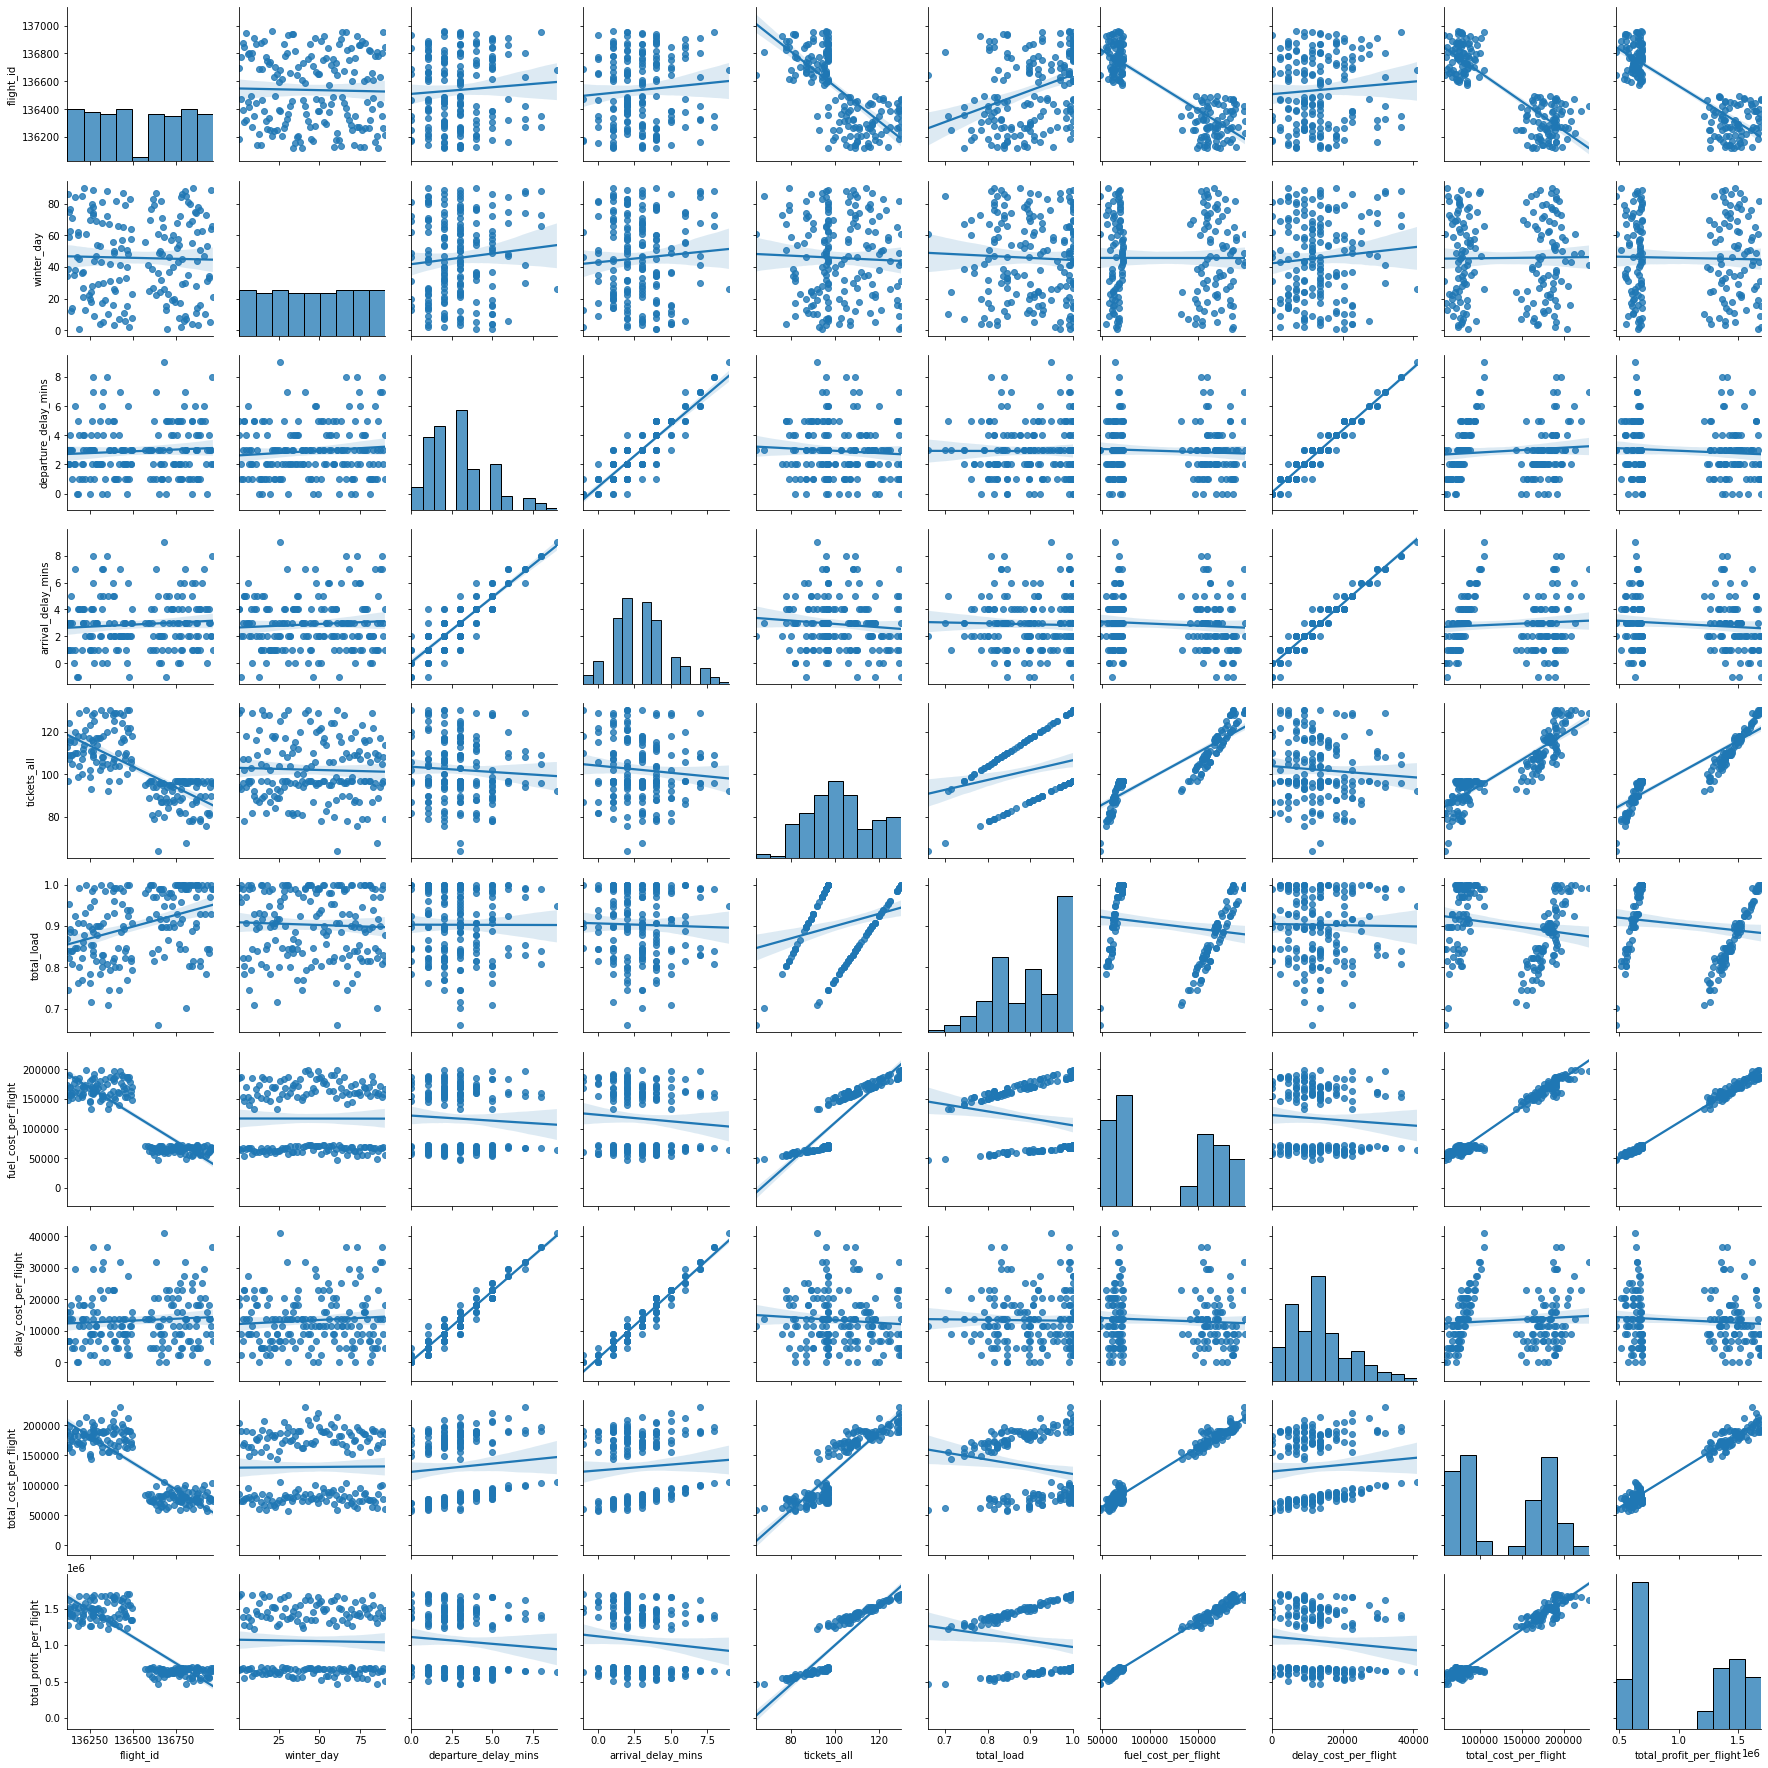

In [61]:
sns.pairplot(dataset, kind='reg')

## 14. Сравнения за один рейс по маркам самолётов 

### 14.1 Прибыль

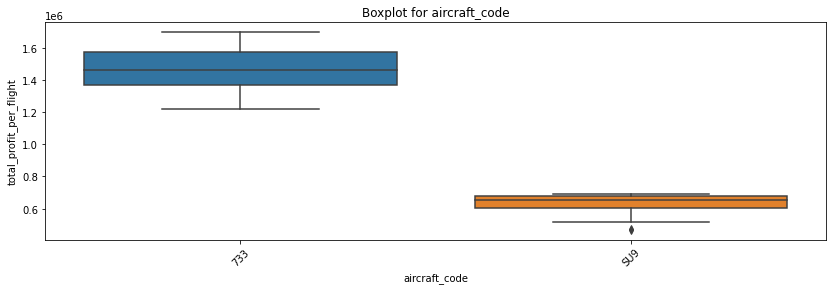

In [62]:
get_boxplot(dataset, "aircraft_code", dataset.total_profit_per_flight)

### 14.2 Затраты

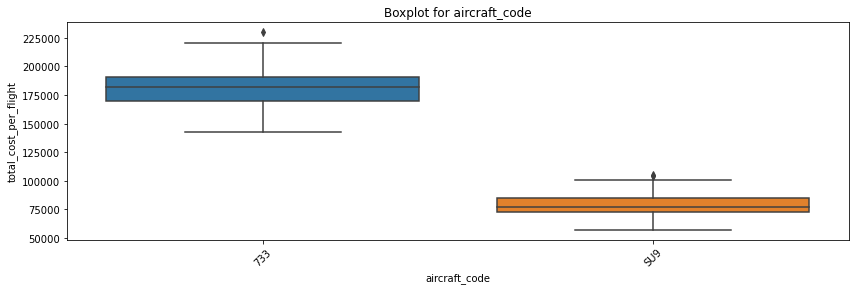

In [63]:
get_boxplot(dataset, "aircraft_code", dataset.total_cost_per_flight)

### 14.3 Загруженность в долях

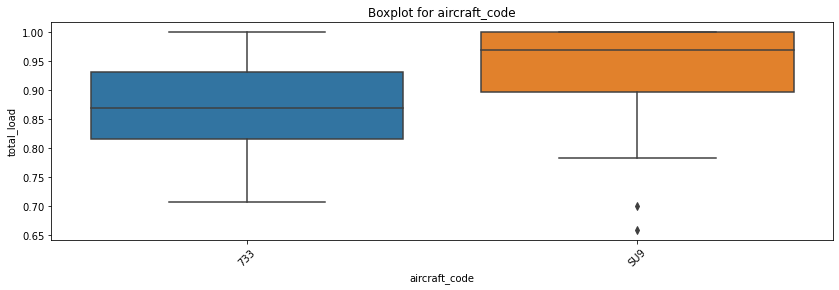

In [64]:
get_boxplot(dataset, "aircraft_code", dataset.total_load)

### 14.4 Задержки

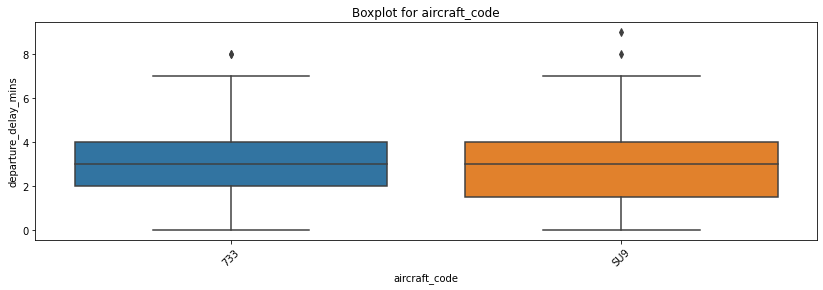

In [65]:
get_boxplot(dataset, "aircraft_code", dataset.departure_delay_mins)

### 14.5 Опоздания

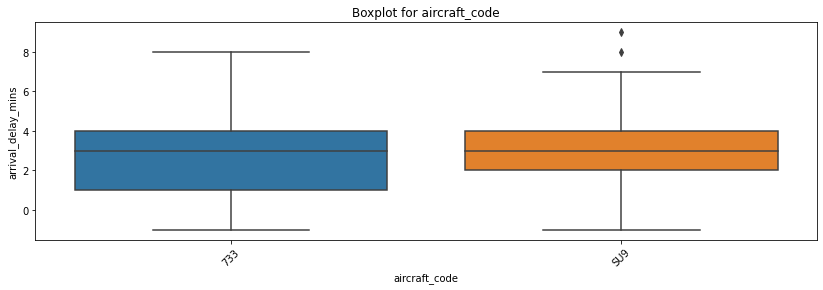

In [66]:
get_boxplot(dataset, "aircraft_code", dataset.arrival_delay_mins)

## 15. Сравнения по временной оси

### 15.1 По месяцам

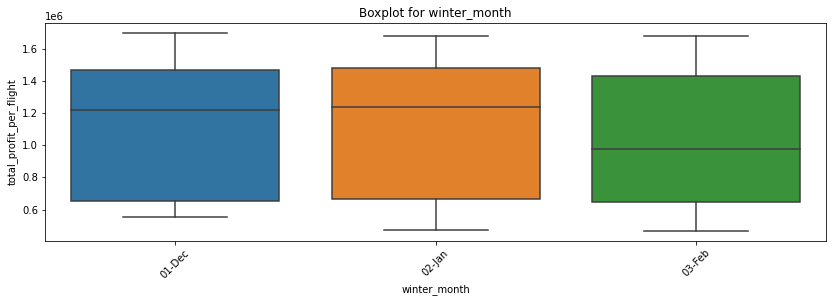

In [67]:
get_boxplot(dataset, "winter_month", dataset.total_profit_per_flight)

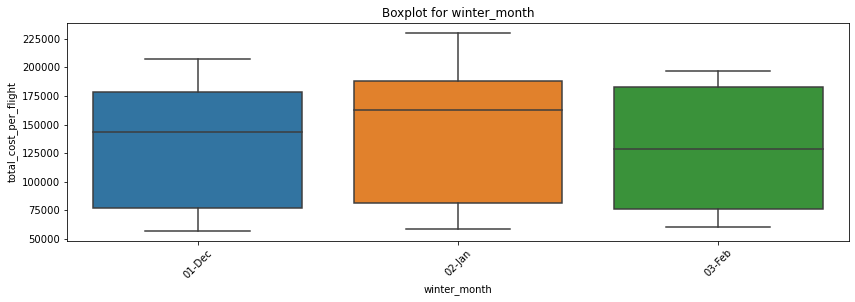

In [68]:
get_boxplot(dataset, "winter_month", dataset.total_cost_per_flight)

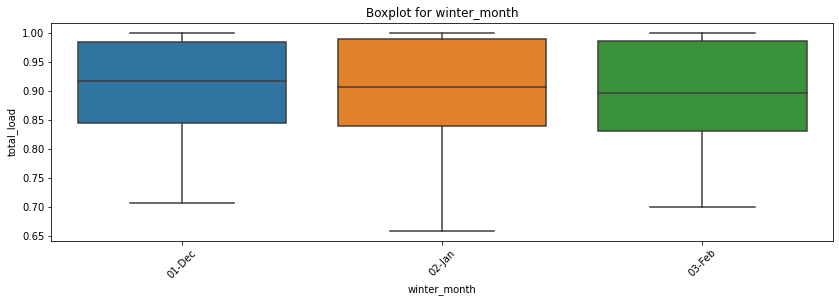

In [69]:
get_boxplot(dataset, "winter_month", dataset.total_load)

#### 15.1.1 По месяцам и самолётам

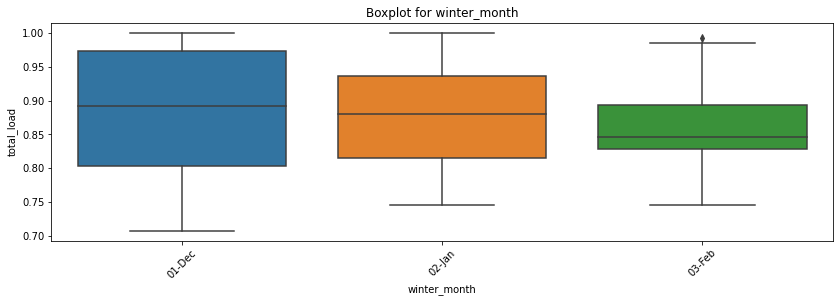

In [70]:
get_boxplot(dataset[dataset.aircraft_code == "733"], "winter_month", dataset.total_load)

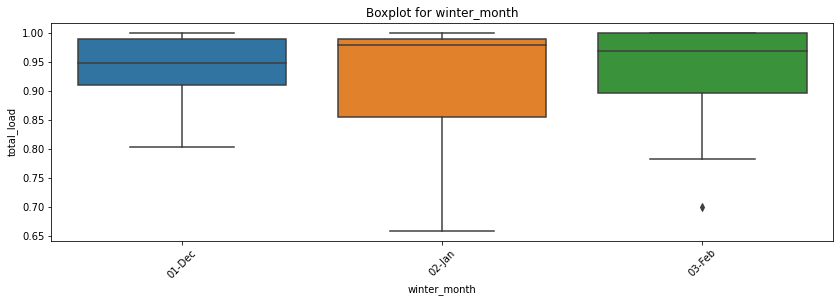

In [71]:
get_boxplot(dataset[dataset.aircraft_code == "SU9"], "winter_month", dataset.total_load)

### 15.2 По дням в зимнее время года

<AxesSubplot:xlabel='winter_day', ylabel='total_cost_per_flight'>

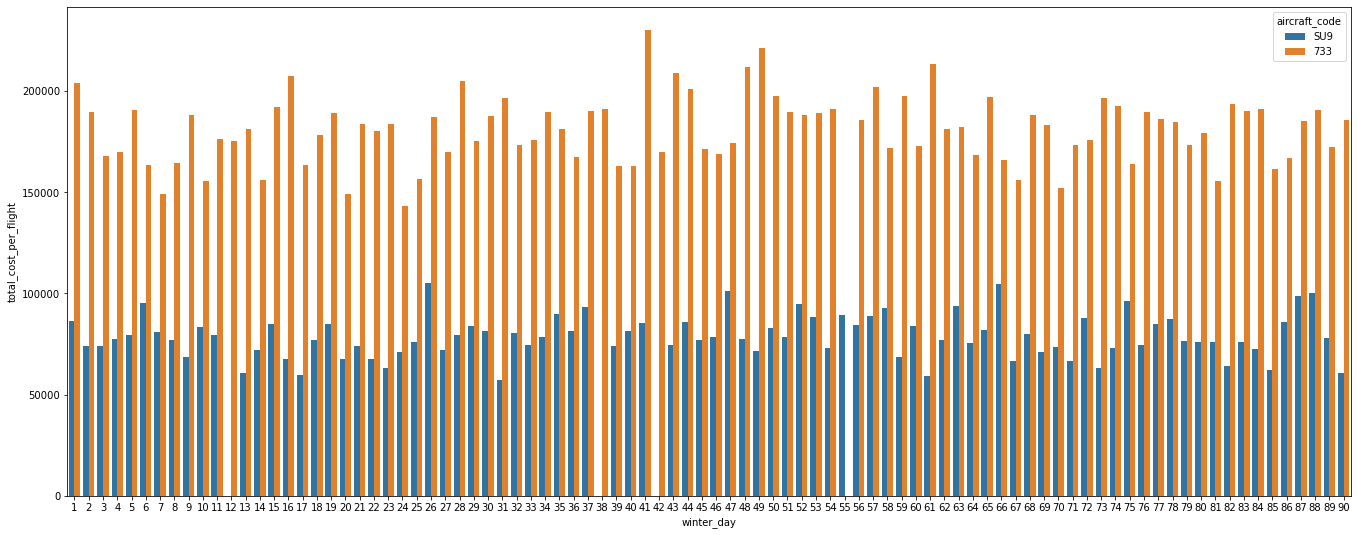

In [76]:
plt_dims = (23, 9)
fig, ax = plt.subplots(figsize=plt_dims)
sns.barplot(x="winter_day", y="total_cost_per_flight", hue="aircraft_code", data=dataset, ax=ax)

## 16. Общие выводы

Из графиков и матрицы коэффициентов корреляции можно сделать ряд предварительных выводов
- Время задержек рейсов время опозданий слабо положительно коррелирует с порядковым номером дня в зимнее время года. То есть чем ближе к концу зимы, тем расходы на задержки рейсов могут быть выше;
- Медианное значение прибыли ниже в феврале, в соответствии с 1-й диаграммой в пункте 15.1;
- Медианное значение относительной загруженности рейса также ниже всего в феврале по 3-й диаграмме пункта 15.1. При этом По первой диаграмме пункта 15.1.1 видно, что снижение загруженности рейса по месяцам спадпет для самолёта Boeing 737-300, а для SSJ-100 меняется мало.
- Из диаграммы в пункте 14.1 видно, что Boeing 737-300 приносим прибыли за рейс намного больше, чем SSJ-100, но при этом по диаграмме загруженности из пункта 14.3 видно, что Boeing 737-300 в среднем загружен меньше, чем SSJ-100. то есть самолёты типа Boeing 737-300 можно было бы использовать более эффективно, если перенести на 737-300 пассажиров с рейсов, где сейчас летает SSJ-100.

<b>Общая рекомендация:</b> перенести пассажирские авиаперевозки с самолётов типа SSJ-100 на самолёты типа Boeing 737-300, чтобы более эффективно использовать более прибыльный самолёт; оптимизировать (уменьшить) колическтво рейсов в феврале месяце так, чтобы повысить загруженность самолётов и эффективно уменьшить расходы на задержки рейсов в аэропортах к концу зимнего периода.

In [77]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176 entries, 13 to 192
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   flight_id                176 non-null    float64       
 1   departure_airport        176 non-null    object        
 2   arrival_airport          176 non-null    object        
 3   winter_day               176 non-null    int64         
 4   winter_month             176 non-null    object        
 5   actual_departure         176 non-null    datetime64[ns]
 6   actual_arrival           176 non-null    datetime64[ns]
 7   departure_delay_mins     176 non-null    float64       
 8   arrival_delay_mins       176 non-null    float64       
 9   tickets_all              176 non-null    float64       
 10  total_load               176 non-null    float64       
 11  fuel_cost_per_flight     176 non-null    float64       
 12  delay_cost_per_flight    176 non-nu